**STOCK PREDICTION FOR TOMORROW**

In [1]:
%pip install yfinance ta scikit-learn matplotlib pandas numpy


Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [3]:
TICKER = "MSFT"
START_DATE = "2015-01-01"

df = yf.download(TICKER, start=START_DATE)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.head()

C:\Users\Madhurima\AppData\Local\Temp\ipykernel_64944\3931814705.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,39.858444,40.421031,39.670917,39.773205,27913900
2015-01-05,39.491913,39.832873,39.423719,39.526007,39673900
2015-01-06,38.912300,39.849945,38.818535,39.534556,36447900
2015-01-07,39.406685,39.602738,38.775907,39.193584,29114100
2015-01-08,40.565941,40.702325,39.824350,39.849921,29645200


*FEATURE ENGINEERING*

In [4]:
close = df["Close"].squeeze()

df["SMA_10"] = close.rolling(10).mean()
df["SMA_50"] = close.rolling(50).mean()
df["RSI"] = ta.momentum.RSIIndicator(close).rsi()
df["MACD"] = ta.trend.MACD(close).macd()
df["Volatility"] = close.pct_change().rolling(10).std()

df["Tomorrow_Close"] = close.shift(-1)
df["Target"] = (df["Tomorrow_Close"] > close).astype(int)

df.dropna(inplace=True)

df.tail()

Price,Close,High,Low,Open,Volume,SMA_10,SMA_50,RSI,MACD,Volatility,Tomorrow_Close,Target
Date,,,,,,,,,,,,
2026-02-06,401.140015,401.790009,392.920013,399.170013,53515300,433.986002,468.879801,29.134424,-18.782936,0.037333,413.600006,1
2026-02-09,413.600006,414.890015,400.869995,404.850006,45480500,428.318002,467.612001,36.100073,-18.631161,0.039431,413.269989,0
2026-02-10,413.269989,423.679993,412.700012,419.619995,44857900,421.587003,466.167401,35.999142,-18.326254,0.037884,404.369995,0
2026-02-11,404.369995,416.459991,401.010010,416.179993,42491000,413.861002,464.414601,33.295569,-18.588492,0.037477,401.839996,0
2026-02-12,401.839996,406.200012,398.010010,405.000000,40802400,410.695001,462.716601,32.547269,-18.783938,0.023429,401.320007,0


*FEATURE MATRIX*

In [5]:
features = ["SMA_10","SMA_50","RSI","MACD","Volatility"]

X = df[features]
y = df["Target"]

X.head()

Price,SMA_10,SMA_50,RSI,MACD,Volatility
Date,,,,,
2015-03-16,36.281567,37.529826,37.147783,-0.490129,0.012252
2015-03-17,36.145930,37.448622,38.817271,-0.493150,0.012150
2015-03-18,36.097854,37.388485,47.412329,-0.435112,0.014098
2015-03-19,36.027458,37.336333,45.601271,-0.399064,0.014116
2015-03-20,36.072099,37.284425,51.236875,-0.325868,0.013750


*Train/Test Split (Time Based)*

In [6]:
split = int(len(df) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

len(X_train), len(X_test)

(2196, 550)

*SCALLING*

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

*MODEL SET-UP*

In [8]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "SVM": SVC(probability=True),
    "GradientBoost": GradientBoostingClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=300)
}

tscv = TimeSeriesSplit(n_splits=5)

*TRAINING AND COMPARING THE MODELS*

In [9]:
rows = []
trained = {}

for name, model in models.items():

    cv_f1 = cross_val_score(
        model, X_train, y_train,
        cv=tscv, scoring="f1"
    ).mean()

    model.fit(X_train, y_train)
    trained[name] = model

    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]

    rows.append({
        "Model": name,
        "CV_F1": round(cv_f1,3),
        "Accuracy": round(accuracy_score(y_test,pred),3),
        "F1": round(f1_score(y_test,pred),3),
        "ROC_AUC": round(roc_auc_score(y_test,prob),3)
    })

results = pd.DataFrame(rows).sort_values("F1", ascending=False)

# SELECTING THE BEST MODEL

best_name = results.iloc[0]["Model"]
best_model = trained[best_name]

print(results)
print("Best Model:", best_name)

           Model  CV_F1  Accuracy     F1  ROC_AUC
1            SVM  0.665     0.529  0.684    0.516
0         LogReg  0.697     0.527  0.633    0.501
3   RandomForest  0.496     0.482  0.215    0.537
2  GradientBoost  0.471     0.495  0.192    0.527
Best Model: SVM


*CONFUSION MATRIX*

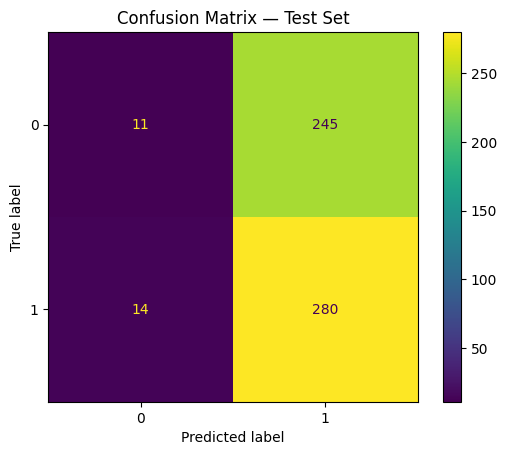

In [10]:
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()

plt.title("Confusion Matrix — Test Set")
plt.show()

*ROC CURVE PLOT*

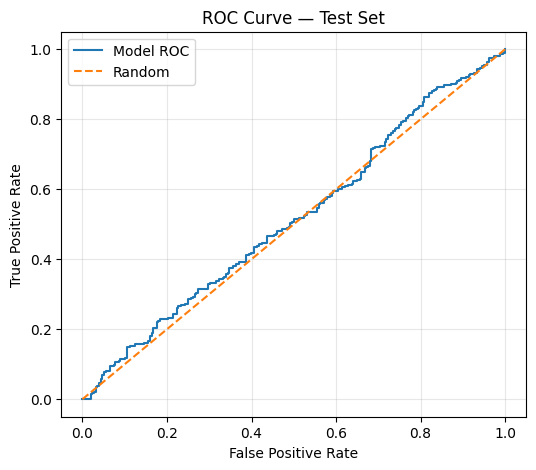

In [11]:
y_prob = best_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test Set")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [12]:
print("INTERPRETATION GUIDE")
print("--------------------")

roc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)

print("ROC AUC:", round(roc,3))
print("F1 Score:", round(f1,3))

if roc > 0.75:
    print("Model has GOOD class separation ability")
elif roc > 0.65:
    print("Model has MODERATE predictive power")
else:
    print("Model has WEAK predictive power")

if f1 > 0.6:
    print("Trading signal quality is usable")
else:
    print("Signal reliability is low — needs tuning")

INTERPRETATION GUIDE
--------------------
ROC AUC: 0.516
F1 Score: 0.684
Model has WEAK predictive power
Trading signal quality is usable


*NEXT DAY PREDICTION AND CONFIDENCE*

In [13]:
latest = scaler.transform(df[features].iloc[-1:])

pred_next = best_model.predict(latest)[0]
prob_up = best_model.predict_proba(latest)[0][1]
prob_down = 1 - prob_up

diff = abs(prob_up - 0.5)

if diff < 0.05:
    confidence = "LOW"
elif diff < 0.15:
    confidence = "MEDIUM"
else:
    confidence = "HIGH"

print("Direction:", "UP" if pred_next==1 else "DOWN")
print("Prob UP:", round(prob_up,3))
print("Prob DOWN:", round(prob_down,3))
print("Confidence:", confidence)

Direction: UP
Prob UP: 0.538
Prob DOWN: 0.462
Confidence: LOW


*BACKTEST STRATEGY*

In [14]:
pred_test = best_model.predict(X_test)

bt = pd.DataFrame(index=y_test.index)
bt["Price"] = df.loc[y_test.index, "Close"]
bt["Pred"] = pred_test

bt["Market_Return"] = bt["Price"].pct_change()
bt["Strategy_Return"] = bt["Market_Return"] * bt["Pred"].shift(1)

bt.fillna(0, inplace=True)

bt["Market_Cum"] = (1 + bt["Market_Return"]).cumprod()
bt["Strategy_Cum"] = (1 + bt["Strategy_Return"]).cumprod()

bt.tail()

,Price,Pred,Market_Return,Strategy_Return,Market_Cum,Strategy_Cum
Date,,,,,,
2026-02-06,401.140015,1,0.018975,0.018975,1.102890,1.081901
2026-02-09,413.600006,1,0.031061,0.031061,1.137148,1.115507
2026-02-10,413.269989,1,-0.000798,-0.000798,1.136240,1.114616
2026-02-11,404.369995,1,-0.021536,-0.021536,1.111771,1.090613
2026-02-12,401.839996,1,-0.006257,-0.006257,1.104815,1.083789


*FEATURE IMPORTANCE*

In [15]:
if best_name == "RandomForest":
    fi = pd.Series(
        best_model.feature_importances_,
        index=features
    ).sort_values(ascending=False)
    fi

*PERFORMANCE PLOTTING*

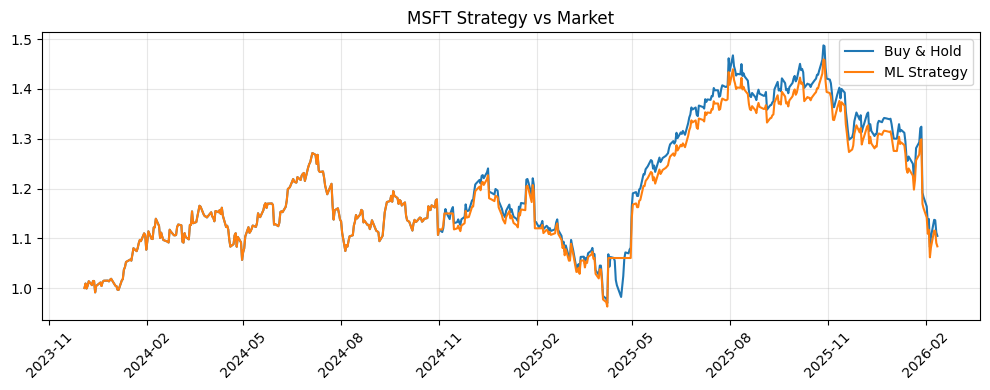

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(bt["Market_Cum"], label="Buy & Hold")
ax.plot(bt["Strategy_Cum"], label="ML Strategy")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.title(f"{TICKER} Strategy vs Market")
plt.tight_layout()

plt.show()

*PERFORMANCE SUMMARY*

In [17]:
market_total = bt["Market_Cum"].iloc[-1] - 1
strategy_total = bt["Strategy_Cum"].iloc[-1] - 1

print("Buy & Hold Return:", round(market_total*100,2), "%")
print("ML Strategy Return:", round(strategy_total*100,2), "%")

Buy & Hold Return: 10.48 %
ML Strategy Return: 8.38 %
